# HW3

In [1]:
from selenium import webdriver
import pandas as pd
import matplotlib.pyplot as plt
from selenium.webdriver.common.by import By
from selenium.common import NoSuchElementException
import re
import time, random
from bs4 import BeautifulSoup
import statsmodels.formula.api as smf
import seaborn as sns

## 1 Data Mining

In [2]:
driver = webdriver.Chrome()

### 1.1 抓取二手房价数据

In [3]:
url_esf = "https://esf.fang.com"
driver.get(url_esf)

# 从主页面定位到重庆沙坪坝区磁器口
driver.find_element(By.CLASS_NAME, "s4Box").click()
driver.find_element(By.XPATH, "//a[contains(@href, 'cq.esf.fang.com')]").click() # 在所有a标签中寻找包含cq.esf.com的标签并点击
driver.find_element(By.CLASS_NAME, "on").click()
driver.find_element(By.XPATH, "//a[contains(@href, 'house-a060')]").click()
driver.find_element(By.XPATH, "//a[contains(@href, 'house-a060-b010129')]").click()

In [4]:
# 获取页数
text = driver.find_element(By.XPATH, "//span[contains(@class,'last')]").text
page_esf = int(re.search(r'\d+', text).group()) # 去掉中文文字，只保留页数
page_esf

25

In [5]:
# 对每一页进行循环抓取
string_list = []
i = 1   # 检查输出页数
print(f"已完成第{i}页html录入")
while i <= page_esf:
    time.sleep(0.5)
    div = driver.find_element(By.XPATH, "//div[contains(@class, 'shop_list_4')]")
    string_list.append(div.get_attribute('outerHTML'))
    i+=1
    try:
        next_href = f"/house-a060-b010129/i3{i}/"
        next_page = driver.find_element(By.XPATH, f"//a[contains(@href, '{next_href}')]")   # 翻页标签每一页都是i3{页码}的形式，如果直接搜前面的部分会出现问题
        next_page.click()
        print(f"已完成第{i}页html录入")    # 用于检查一共输出了多少页
        time.sleep(random.uniform(5,10))   # 防止图形验证，因此总时间会长一些
    except NoSuchElementException:
        break

已完成第1页html录入
已完成第2页html录入
已完成第3页html录入
已完成第4页html录入
已完成第5页html录入
已完成第6页html录入
已完成第7页html录入
已完成第8页html录入
已完成第9页html录入
已完成第10页html录入
已完成第11页html录入
已完成第12页html录入
已完成第13页html录入
已完成第14页html录入
已完成第15页html录入
已完成第16页html录入
已完成第17页html录入
已完成第18页html录入
已完成第19页html录入
已完成第20页html录入
已完成第21页html录入
已完成第22页html录入
已完成第23页html录入
已完成第24页html录入
已完成第25页html录入


In [6]:
driver.quit()

In [7]:
full_data_esf = []
# 爬取总价、面积、每平方米价格
i = 1
for html in string_list:
    soup_esf = BeautifulSoup(html,"lxml")
    container = soup_esf.select_one("div.shop_list.shop_list_4")
    houses = container.select("dl.clearfix")    # 找出所有class为clearfix的dl，这些就是所有的房间

    # 为了抓取的数据相互匹配，此处将一页的数据分为几个house
    for house in houses:
        total_price = house.select_one("dd.price_right span.red b").get_text(strip = True) # 一个house里的price
        total_price_ad = float(total_price) * 10000 # 改为以元为单位

        price_m2_tag = house.select_one("dd.price_right > span:not(.red)").get_text(strip = True)   # 寻找子元素span中不含red的部分
        price_m2_re = re.search(r"(\d+(?:\.\d+)?)\s*元/㎡", price_m2_tag)   # 采用正则表达式保留数字
        price_m2 = float(price_m2_re.group(1))

        info_tag = house.select_one("p.tel_shop").get_text(" ", strip = True) # 内含其他数据，采用正则表达式筛选
        m2_re = re.search(r"(\d+(?:\.\d+)?)\s*㎡", info_tag)
        m2_num = float(m2_re.group(1))
        full_data_esf.append(
            {
                "总价（元）": total_price_ad,
                "每平米价格（元）": price_m2,
                "面积（㎡）": m2_num}
        )
# 转化为dataframe
df_esf = pd.DataFrame(full_data_esf)
df_esf.to_excel("重庆-沙坪坝-磁器口.xlsx",sheet_name="二手房", index=False)

### 2.2 抓取租房数据

In [8]:
driver = webdriver.Chrome()
url_rent = "https://zu.fang.com/"
driver.get(url_rent)

In [ ]:
# 定位到重庆沙坪坝磁器口
driver.find_element(By.CLASS_NAME, "s4Box").click()
time.sleep(1)   # 防止还没有加载出来（出现过这样的问题）
driver.find_element(By.XPATH, "//a[contains(@href, 'cq.zu.fang.com')]").click() # 在所有a标签中寻找包含cq.esf.com的标签并点击
driver.find_element(By.XPATH, "//a[contains(@href, '/house-a060/')]").click()
driver.find_element(By.XPATH, "//div[@class = 'quYu']//a[contains(@href, '/house-a060-b010129/')]").click()

In [ ]:
# 抓取页面数
page_rent_str = driver.find_element(By.XPATH, "//div[@class = 'fanye']//span[@class = 'txt']").text
page_rent = int(re.search(r"\d+", page_rent_str).group())

# 爬取每个页面的数据并存储
string_list_rent = []
i = 1
print(f"成功抓取第{i}页数据")
while i <= page_rent:
    div = driver.find_element(By.CLASS_NAME, "houseList")
    string_list_rent.append(div.get_attribute("outerHTML"))
    i+=1
    # 翻页
    try:
        time.sleep(random.uniform(3,6))    # 防止机器验证
        next_page = driver.find_element(By.XPATH, f"//div[@class = 'fanye']//a[contains(@href, 'house-a060-b010129/i3{i}')]")
        next_page.click()
        print(f"成功抓取第{i}页数据")
    except NoSuchElementException:
        break

成功抓取第1页数据
成功抓取第2页数据
成功抓取第3页数据
成功抓取第4页数据
成功抓取第5页数据
成功抓取第6页数据
成功抓取第7页数据


In [11]:
driver.quit()

In [ ]:
# 数据处理
full_data_rent = []
for html in string_list_rent:
    soup_rent = BeautifulSoup(html,"lxml")
    houses = soup_rent.select("dl.list.hiddenMap.rel")
    for house in houses:
        monthly_price = float(house.select_one("dd.info.rel div.moreInfo p.mt5.alingC span.price").get_text(strip = True))
        house_info = house.select_one("dd.info.rel p.font15.mt12.bold").get_text(" ", strip = True)
        m2_tag = re.search(r"(\d+(?:\.\d+)?)\s*㎡", house_info) # 由于包含多条信息，仍然用正则表达式筛选
        m2_num = float(m2_tag.group(1))
        print(monthly_price, m2_num)    # 检查输出

        full_data_rent.append(
            {
                "面积（㎡）": m2_num,
                "每月租价（元）": monthly_price
            })
df_rent = pd.DataFrame(full_data_rent)
with pd.ExcelWriter("重庆-沙坪坝-磁器口.xlsx", engine="openpyxl", mode="a", if_sheet_exists="new") as writer:
    df_rent.to_excel(writer,sheet_name="租房",index = False)

3300.0 118.0
2000.0 78.0
1100.0 32.0
1660.0 73.0
1500.0 89.0
1200.0 32.0
1500.0 57.0
1100.0 58.0
2500.0 105.0
1700.0 66.0
1500.0 38.0
1800.0 79.0
1700.0 86.0
1600.0 71.0
1000.0 108.0
1500.0 88.0
800.0 39.0
1500.0 71.0
1200.0 45.0
2000.0 81.0
800.0 65.0
2100.0 78.0
1300.0 63.0
1500.0 64.0
1650.0 56.0
1650.0 69.0
3900.0 135.0
1500.0 75.0
1300.0 45.0
2600.0 86.0
4500.0 135.0
2400.0 80.0
2100.0 77.0
1800.0 69.0
1100.0 42.0
800.0 37.0
4500.0 130.0
1200.0 45.0
2800.0 105.0
1500.0 145.0
700.0 51.0
1600.0 60.0
900.0 35.0
2200.0 42.0
1700.0 80.0
2200.0 101.0
1700.0 80.0
2600.0 74.0
1500.0 97.0
2000.0 56.0
1600.0 85.0
2600.0 104.0
1400.0 63.0
1800.0 75.0
1800.0 80.0
1600.0 120.0
3000.0 80.0
1800.0 79.0
2300.0 101.0
1200.0 42.0
1800.0 75.0
2300.0 95.0
2000.0 78.0
3000.0 94.0
2100.0 83.0
1300.0 45.0
1100.0 42.0
2100.0 80.0
2000.0 150.0
1800.0 118.0
1800.0 83.0
2100.0 101.0
1500.0 88.0
2000.0 79.0
1600.0 61.0
1900.0 57.0
1000.0 66.0
1700.0 76.0
1800.0 85.0
2000.0 133.0
1100.0 57.0
3000.0 71.0
2400.

## 2 Data Mining (Group)

### 2.1 数据整合

In [ ]:
# 生成虚拟变量，由于python可以自动把str转换为虚拟变量处理，此处就直接使用block名
def locate(path, loc):
    sheet = pd.read_excel(path, sheet_name = None)
    with pd.ExcelWriter(path, engine = "openpyxl") as writer:
        for name, df in sheet.items():
            df["location"] = loc
            df.to_excel(writer, sheet_name = name, index = False)

# 此处由于前期小组成员没有统一数据格式，另做清洗（下次作业整改）
def rename_col(path, total, price_per_m2, area_esf, area_rent, price_rent):
    all_sheets = pd.read_excel(path, sheet_name = None) # 分开sheet重命名
    # 存为_处理后文件
    with pd.ExcelWriter(path.replace(".xlsx", "_处理后.xlsx"), engine = "openpyxl", mode = "w") as writer:
        for sheet, df in all_sheets.items():   
            if "二手房" in sheet:   # 防止不同表格sheet有不同命名方式
                df.rename(columns={
                    total: "total_price",
                    price_per_m2: "price_per_m2",
                    area_esf: "area_esf",
                }, inplace=True)
                # 防止单位混乱
                if df["total_price"].mean() < 10000:    # 统一以元为单位，以平均数判断
                    df["total_price"] = df["total_price"] * 10000
                df.to_excel(writer, sheet_name = "二手房", index = False)

            elif "租房" in sheet:
                df.rename(columns={
                    area_rent: "area_rent",
                    price_rent: "price_rent"
                }, inplace=True)
                df["rent_per_m2"] = df["price_rent"] / df["area_rent"]
                df.to_excel(writer, sheet_name = "租房", index = False)


path_cqk = "重庆-沙坪坝-磁器口.xlsx"
path_sxdq = "重庆-沙坪坝-三峡大桥.xlsx"
path_dxc = "重庆-沙坪坝-大学城.xlsx"
path_cjq = "重庆-沙坪坝-陈家桥.xlsx"
# 加入地名
locate(path_cqk, "磁器口")
locate(path_sxdq, "三峡大桥")
locate(path_dxc, "大学城")
locate(path_cjq, "陈家桥")
# 修改列名使其统一
rename_col(path_cqk, "总价（元）", "每平米价格（元）", "面积（㎡）", "面积（㎡）","每月租价（元）" )
rename_col(path_sxdq, "总价(万元)", "单价(元/㎡)", "面积(㎡)", "面积(㎡)", "月租金(元)")
rename_col(path_dxc, "总价格", "平米价格", "面积", "面积", "价格")
rename_col(path_cjq, "总价(万)", "单价(元/㎡)", "面积(㎡)", "面积(㎡)", "总价(元)")



In [14]:
# 合成两个大表，先全部读取为df
df_cqk_rent = pd.read_excel("重庆-沙坪坝-磁器口_处理后.xlsx", sheet_name = "租房")
df_cqk_esf = pd.read_excel("重庆-沙坪坝-磁器口_处理后.xlsx", sheet_name = "二手房")
df_sxdq_rent = pd.read_excel("重庆-沙坪坝-三峡大桥_处理后.xlsx", sheet_name = "租房")
df_sxdq_esf = pd.read_excel("重庆-沙坪坝-三峡大桥_处理后.xlsx", sheet_name = "二手房")
df_dxc_rent = pd.read_excel("重庆-沙坪坝-大学城_处理后.xlsx", sheet_name = "租房")
df_dxc_esf = pd.read_excel("重庆-沙坪坝-大学城_处理后.xlsx", sheet_name = "二手房")
df_cjq_rent = pd.read_excel("重庆-沙坪坝-陈家桥_处理后.xlsx", sheet_name = "租房")
df_cjq_esf = pd.read_excel("重庆-沙坪坝-陈家桥_处理后.xlsx", sheet_name = "二手房")

# 再合成为rent和esf两个表
df_full_data_esf = pd.concat([df_cqk_esf, df_sxdq_esf, df_dxc_esf, df_cjq_esf], ignore_index = True)
df_full_data_rent = pd.concat([df_cqk_rent, df_sxdq_rent, df_dxc_rent, df_cjq_rent], ignore_index = True)

display(df_full_data_esf, df_full_data_rent)

,total_price,price_per_m2,area_esf,location
0,990000,8918,111.00,磁器口
1,1200000,11754,102.09,磁器口
2,1070000,9639,111.00,磁器口
3,880000,11578,76.00,磁器口
4,1780000,15932,111.72,磁器口
...,...,...,...,...
4136,607000,5842,103.90,陈家桥
4137,680000,6513,104.40,陈家桥
4138,570000,5558,102.56,陈家桥
4139,540000,6881,78.48,陈家桥


,area_rent,price_rent,location,rent_per_m2
0,118,3300,磁器口,27.966102
1,78,2000,磁器口,25.641026
2,32,1100,磁器口,34.375000
3,73,1660,磁器口,22.739726
4,89,1500,磁器口,16.853933
...,...,...,...,...
2827,75,1800,陈家桥,24.000000
2828,75,1200,陈家桥,16.000000
2829,231,800,陈家桥,3.463203
2830,104,1600,陈家桥,15.384615


## 3 Data Research

In [ ]:
# 在df中不使用科学计数法并保留两位小数
pd.options.display.float_format = '{:,.2f}'.format

### 3.1 磁器口

In [16]:
display(df_cqk_esf.describe(), df_cqk_rent.describe())

# 使用拆开的表方便输出
ptor_cqk = df_cqk_esf["total_price"].median() / df_cqk_rent["price_rent"].median()
print(f"重庆-沙坪坝-磁器口的price to rent ratio为{ptor_cqk}")

,total_price,price_per_m2,area_esf
count,"1,484.00","1,484.00","1,484.00"
mean,"1,303,782.88","12,691.55",98.91
std,"807,592.95","4,542.66",41.89
min,"180,000.00","3,903.00",32.00
25%,"720,000.00","9,739.50",73.00
50%,"1,150,000.00","11,838.50",94.90
75%,"1,700,000.00","14,756.25",126.10
max,"6,800,000.00","37,038.00",287.67


,area_rent,price_rent,rent_per_m2
count,384.00,384.00,384.00
mean,76.33,"1,826.66",25.05
std,36.94,"1,228.24",8.29
min,32.00,600.00,5.41
25%,45.75,"1,200.00",20.19
50%,75.00,"1,600.00",24.44
75%,94.00,"2,100.00",29.31
max,300.00,"15,000.00",71.43


重庆-沙坪坝-磁器口的price to rent ratio为718.75


分析结果：
- 可见磁器口租房、二手房数据差异较大（std数值大），但价格、面积极值均较为合理，不存在outlier

- 不存在缺失值

### 3.2 三峡大桥

In [17]:
display(df_sxdq_esf.describe(), df_sxdq_rent.describe())
ptor_sxdq = df_sxdq_esf["total_price"].median() / df_sxdq_rent["price_rent"].median()
print(f"重庆-沙坪坝-三峡大桥的price to rent ratio为{ptor_sxdq}")

,area_esf,price_per_m2,total_price
count,"1,200.00","1,200.00","1,200.00"
mean,81.69,"12,662.86","1,068,654.17"
std,38.68,"4,203.36","717,580.02"
min,26.66,"4,871.00","150,000.00"
25%,50.45,"9,374.75","528,000.00"
50%,76.25,"12,037.50","840,000.00"
75%,107.71,"15,710.75","1,400,000.00"
max,391.73,"27,163.00","5,150,000.00"


,area_rent,price_rent,rent_per_m2
count,"1,200.00","1,200.00","1,200.00"
mean,70.75,"1,997.21",29.34
std,39.37,"1,353.33",10.90
min,23.00,600.00,5.13
25%,45.00,"1,250.00",23.03
50%,58.00,"1,500.00",29.48
75%,87.00,"2,400.00",34.38
max,386.00,"15,000.00",150.00


重庆-沙坪坝-三峡大桥的price to rent ratio为560.0


分析结果：

- 三峡大桥地区的租房、二手房价格、面积差异大，但均在合理范围之内，判断不存在outlier

- 不存在缺失值

### 3.3 大学城

In [18]:
display(df_dxc_esf.describe(), df_dxc_rent.describe())
ptor_dxc = df_dxc_esf["total_price"].median() / df_dxc_rent["price_rent"].median()
print(f"重庆-沙坪坝-大学城的price to rent ratio为{ptor_dxc}")

,total_price,price_per_m2,area_esf
count,"1,200.00","1,200.00","1,200.00"
mean,"1,103,472.83","9,682.37",107.39
std,"841,594.55","3,095.42",44.85
min,"135,000.00","4,144.00",28.43
25%,"680,000.00","7,694.00",82.00
50%,"870,000.00","9,104.50",96.60
75%,"1,200,000.00","10,715.25",123.73
max,"10,000,000.00","31,948.00",326.18


,price_rent,area_rent,rent_per_m2
count,"1,200.00","1,200.00","1,200.00"
mean,"1,656.80",76.93,22.56
std,"1,140.42",36.83,8.44
min,300.00,20.00,1.47
25%,"1,200.00",48.00,17.98
50%,"1,500.00",76.00,21.24
75%,"1,800.00",92.00,26.10
max,"15,000.00",400.00,94.59


重庆-沙坪坝-大学城的price to rent ratio为580.0


分析结果：

大学城的租房价格300元远小于在25%的值，但未知是否为合理值（可能存在位置很差、面积很小的房屋；也有可能存在数据的集中分布，比如在300附近的价格很多，导致虽然25%的是1200元，仍然有可能是合理值），因此画数据分布箱线图具体分析

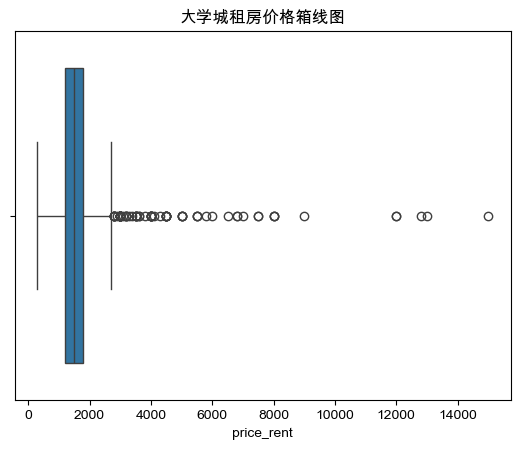

In [19]:
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 设置中文字体

# 绘制箱线图
sns.boxplot(x = df_dxc_rent["price_rent"])
plt.title("大学城租房价格箱线图")
plt.show()

- 可见300元的租房价格不是异常值

- 但是存在更大的异常值，但这些异常值在现实生活中较为合理（根据地段、面积等等），也与最终模型的训练有关，推测应该不是数据录入有误，因此不做删除

- 此处也可用取ln来使得数据的分布更加均匀，但model中没有要求，此处不做处理

### 3.4 陈家桥

In [20]:
display(df_cjq_esf.describe(), df_cjq_rent.describe())
ptor_cjq = df_cjq_esf["total_price"].median() / df_cjq_rent["price_rent"].median()
print(f"重庆-沙坪坝-陈家桥的price to rent ratio为{ptor_cjq}")

,total_price,area_esf,price_per_m2
count,257.00,257.00,257.00
mean,"988,459.14",108.66,"8,469.68"
std,"713,813.20",38.25,"3,959.20"
min,"200,000.00",30.88,"3,528.00"
25%,"499,000.00",87.74,"5,842.00"
50%,"660,000.00",103.88,"6,796.00"
75%,"1,610,000.00",128.52,"10,697.00"
max,"3,810,000.00",227.00,"24,767.00"


,price_rent,area_rent,rent_per_m2
count,48.00,48.00,48.00
mean,"1,557.29",89.42,19.03
std,480.69,34.44,7.00
min,800.00,30.00,3.46
25%,"1,200.00",67.25,13.97
50%,"1,500.00",90.50,17.82
75%,"1,800.00",102.25,22.05
max,"3,000.00",231.00,43.33


重庆-沙坪坝-陈家桥的price to rent ratio为440.0


分析结果：

- 陈家桥地区的租房、二手房价格、面积差异较小，判断不存在outlier

- 不存在缺失值

### 3.5 Figure A: Original Price to Rent Ratio

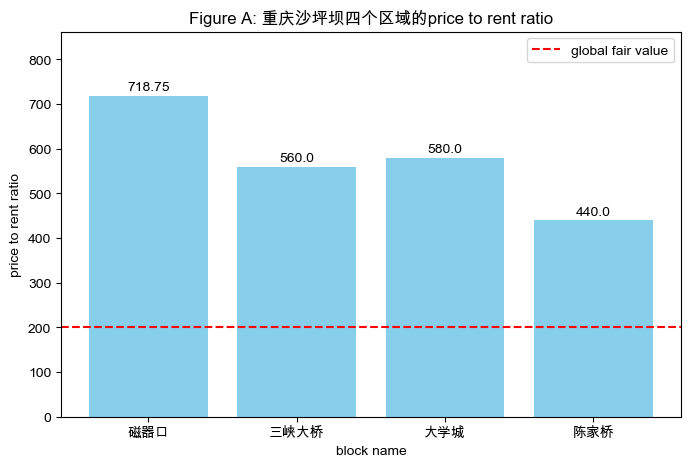

In [21]:
# 把四个block的ratio手动整合为一个df
df_ratio = pd.DataFrame({
    "block": ["磁器口", "三峡大桥", "大学城", "陈家桥"],
    "price_to_rent ratio": [ptor_cqk, ptor_sxdq, ptor_dxc, ptor_cjq]
})

plt.figure(figsize=(8, 5))   # 设置图片大小

plt.bar(df_ratio["block"], df_ratio["price_to_rent ratio"], color = 'skyblue')
plt.ylim(0, max(df_ratio["price_to_rent ratio"])*1.2)  # 设置y的显示范围便于显示柱子数值

# 加入每个柱子的数值显示
for i, ratio in enumerate(df_ratio["price_to_rent ratio"]):
    plt.text(
        i, 
        ratio + 5, # 在ratio上面五个单位
        str(ratio), 
        ha = "center",
        va = "bottom"
        )

plt.axhline(y = 200, color = "red", linestyle = "--", label = "global fair value")  # 加入global fair value作为参考
plt.title("Figure A: 重庆沙坪坝四个区域的price to rent ratio")
plt.xlabel("block name")
plt.ylabel("price to rent ratio")

plt.legend()    # 显示所有图例
plt.show()

四个block的比率都远大于世界平均值，证明房价偏高、租价偏低，租房可能更划算

## 4 Data Science Modeling

In [22]:
# 生成回归模型
model1 = smf.ols('price_per_m2 ~ area_esf + location', data = df_full_data_esf).fit()
model2 = smf.ols('rent_per_m2 ~ area_rent + location', data = df_full_data_rent).fit()
display(model1.summary())
display(model2.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_per_m2   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     269.9
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          2.07e-206
Time:                        16:18:40   Log-Likelihood:                -40061.
No. Observations:                4141   AIC:                         8.013e+04
Df Residuals:                    4136   BIC:                         8.016e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.031e+04    161.651     63.772      0.000    9991.865    1.06e+04
location[T.大学城] -3721.1428    161.477    -23.044      0.000   -4037.725   -3404.560
location[T.磁器口]  -467.7811    151.524     -3.087      0.002    -764.849    -170.713
location[T.陈家桥] -4970.6054    267.488    -18.583      0.000   -5495.026   -4446.185
area_esf           28.8186      1.437     20.057      0.000      26.002      31.636
==============================================================================
Omnibus:                      859.116   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2504.235
Skew:                           1.076   Prob(JB):                         0.00
Kurtosis:                       6.143   Cond. No.                         510.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_per_m2   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     124.3
Date:                Wed, 15 Oct 2025   Prob (F-statistic):           7.05e-98
Time:                        16:18:40   Log-Likelihood:                -10327.
No. Observations:                2832   AIC:                         2.066e+04
Df Residuals:                    2827   BIC:                         2.069e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          33.3209      0.422     78.963      0.000      32.493      34.148
location[T.大学城]    -6.4296      0.380    -16.914      0.000      -7.175      -5.684
location[T.磁器口]    -3.9743      0.545     -7.292      0.000      -5.043      -2.906
location[T.陈家桥]    -9.2637      1.369     -6.764      0.000     -11.949      -6.578
area_rent          -0.0563      0.005    -12.216      0.000      -0.065      -0.047
==============================================================================
Omnibus:                     2214.288   Durbin-Watson:                   2.036
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           111040.155
Skew:                           3.264   Prob(JB):                         0.00
Kurtosis:                      32.973   Cond. No.                         658.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

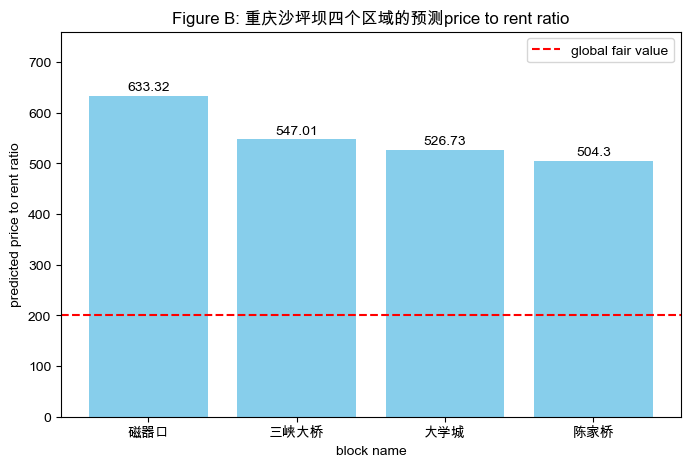

In [ ]:
def pred_ptor(df_esf, df_rent):
    # 先预测price和rent
    df_esf["pred_price"] = model1.predict(df_esf) * df_esf["area_esf"]  # 因为预测出来的是每平米的价格，此处还需要再乘m2
    df_rent["pred_rent"] = model2.predict(df_rent) * df_rent["area_rent"]
    # 此处计算ratio时直接用预测的 每平米价格/每平米租价（都取中位数），这样消掉m2后得出结果
    pred_ptor = round(df_esf["pred_price"].median() / df_rent["pred_rent"].median(), 2) # 保留两位小数
    return pred_ptor

# 调用函数得出每个预测的ptor
pred_ptor_cqk = pred_ptor(df_cqk_esf, df_cqk_rent)
pred_ptor_sxdq = pred_ptor(df_sxdq_esf, df_sxdq_rent)
pred_ptor_dxc = pred_ptor(df_dxc_esf, df_dxc_rent)
pred_ptor_cjq = pred_ptor(df_cjq_esf, df_cjq_rent)

# 作图
df_pred_ratio = pd.DataFrame({
    "block": ["磁器口", "三峡大桥", "大学城", "陈家桥"],
    "price_to_rent ratio": [pred_ptor_cqk, pred_ptor_sxdq, pred_ptor_dxc, pred_ptor_cjq]
})

plt.figure(figsize=(8, 5))   # 设置图片大小

plt.bar(df_pred_ratio["block"], df_pred_ratio["price_to_rent ratio"], color = 'skyblue')
plt.ylim(0, max(df_pred_ratio["price_to_rent ratio"])*1.2)  # 设置y的显示范围便于显示柱子数值

# 加入每个柱子的数值显示
for i, ratio in enumerate(df_pred_ratio["price_to_rent ratio"]):
    plt.text(
        i, 
        ratio + 5, # 在ratio上面五个单位
        str(ratio), 
        ha = "center",
        va = "bottom"
        )

plt.axhline(y = 200, color = "red", linestyle = "--", label = "global fair value")
plt.title("Figure B: 重庆沙坪坝四个区域的预测price to rent ratio")
plt.xlabel("block name")
plt.ylabel("predicted price to rent ratio")


plt.legend()    # 显示所有图例
plt.show()

## 5 Data Science Modeling Pro Max

In [24]:
# 重新建立两个plus model
model1_plus = smf.ols('price_per_m2 ~ area_esf + location + I(area_esf ** 2) + area_esf:location', data = df_full_data_esf).fit()
model2_plus = smf.ols('rent_per_m2 ~ area_rent + location + I(area_rent ** 2) + area_rent:location', data = df_full_data_rent).fit()

display(model1_plus.summary())
display(model2_plus.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           price_per_m2   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     149.6
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          1.12e-221
Time:                        16:18:40   Log-Likelihood:                -40015.
No. Observations:                4141   AIC:                         8.005e+04
Df Residuals:                    4132   BIC:                         8.011e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 9407.9118    300.291     31.329      0.000    8819.180    9996.643
location[T.大学城]          -6304.1913    433.805    -14.532      0.000   -7154.682   -5453.700
location[T.磁器口]          -1351.9902    365.869     -3.695      0.000   -2069.290    -634.691
location[T.陈家桥]          -7982.8360    764.490    -10.442      0.000   -9481.648   -6484.024
area_esf                    55.5200      4.636     11.975      0.000      46.430      64.610
area_esf:location[T.大学城]    25.5078      4.201      6.072      0.000      17.271      33.744
area_esf:location[T.磁器口]     9.6288      3.738      2.576      0.010       2.300      16.958
area_esf:location[T.陈家桥]    28.4450      6.864      4.144      0.000      14.988      41.902
I(area_esf ** 2)            -0.1568      0.018     -8.900      0.000      -0.191      -0.122
==============================================================================
Omnibus:                      872.033   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2520.732
Skew:                           1.095   Prob(JB):                         0.00
Kurtosis:                       6.133   Cond. No.                     2.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            rent_per_m2   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     86.40
Date:                Wed, 15 Oct 2025   Prob (F-statistic):          2.03e-128
Time:                        16:18:40   Log-Likelihood:                -10246.
No. Observations:                2832   AIC:                         2.051e+04
Df Residuals:                    2823   BIC:                         2.056e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    38.2686      0.682     56.151      0.000      36.932      39.605
location[T.大学城]              -4.7570      0.813     -5.854      0.000      -6.350      -3.164
location[T.磁器口]              -2.6412      1.188     -2.224      0.026      -4.970      -0.313
location[T.陈家桥]              -1.4732      3.701     -0.398      0.691      -8.730       5.783
area_rent                    -0.1765      0.012    -14.813      0.000      -0.200      -0.153
area_rent:location[T.大学城]    -0.0172      0.010     -1.764      0.078      -0.036       0.002
area_rent:location[T.磁器口]    -0.0132      0.014     -0.932      0.351      -0.041       0.015
area_rent:location[T.陈家桥]    -0.0778      0.039     -2.005      0.045      -0.154      -0.002
I(area_rent ** 2)             0.0005   4.28e-05     12.699      0.000       0.000       0.001
==============================================================================
Omnibus:                     2358.250   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           139537.379
Skew:                           3.552   Prob(JB):                         0.00
Kurtosis:                      36.646   Cond. No.                     2.65e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [25]:
# 输出四个模型的拟合优度进行对比
print(f"model1的R^2为{model1.rsquared}, model1_plus的R^2为{model1_plus.rsquared}")
print(f"model2的R^2为{model2.rsquared}, model2_plus的R^2为{model2_plus.rsquared}")

model1的R^2为0.20701230762113842, model1_plus的R^2为0.22454323227785744
model2的R^2为0.14960184532280807, model2_plus的R^2为0.1966806550782343


plus模型的拟合优度都大于不加入交叉项和平方项的模型，说明加入的交互项和二次项的解释能力较强
- 添加交互项 area*location，由于location是一个多类别虚拟变量，此处意味着允许不同地点的回归方程（斜率和截距）完全不同，这可以增加准确性，因为不同地点的面积增加一平米时，房价每平米上升幅度相同的可能性不大

- 添加二次项area_rent^2, 因为area对每平米价格的影响可能与area自身有关系，不是一个线性的过程。比如小户型由于总价便宜、需求高可能每平米价格更高

因此因变量样本变异能更好地被解释变量解释，但可能仍然存在内生性问题

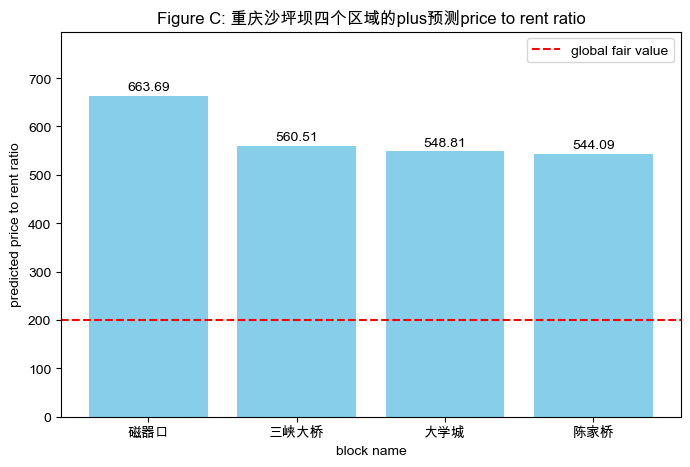

In [26]:
# 预测、计算price to rent ratio并绘图
def pred_ptor(df_esf, df_rent):
    # 先预测
    df_esf["plus_pred_price"] = model1_plus.predict(df_esf) * df_esf["area_esf"]
    df_rent["plus_pred_rent"] = model2_plus.predict(df_rent) * df_rent["area_rent"]
    # 此处计算ratio时直接用预测的 每平米价格/每平米租价（都取中位数），这样消掉m2后得出结果
    pred_ptor = round(df_esf["plus_pred_price"].median() / df_rent["plus_pred_rent"].median(), 2)
    return pred_ptor

# 调用函数得出每个预测的ptor
plus_pred_ptor_cqk = pred_ptor(df_cqk_esf, df_cqk_rent)
plus_pred_ptor_sxdq = pred_ptor(df_sxdq_esf, df_sxdq_rent)
plus_pred_ptor_dxc = pred_ptor(df_dxc_esf, df_dxc_rent)
plus_pred_ptor_cjq = pred_ptor(df_cjq_esf, df_cjq_rent)

# 作图
df_plus_pred_ratio = pd.DataFrame({
    "block": ["磁器口", "三峡大桥", "大学城", "陈家桥"],
    "price_to_rent ratio": [plus_pred_ptor_cqk, plus_pred_ptor_sxdq, plus_pred_ptor_dxc, plus_pred_ptor_cjq]
})

plt.figure(figsize=(8,5))   # 设置图片大小
plt.bar(df_plus_pred_ratio["block"], df_plus_pred_ratio["price_to_rent ratio"], color = 'skyblue')
plt.ylim(0, max(df_plus_pred_ratio["price_to_rent ratio"])*1.2)  # 设置y的显示范围便于显示柱子数值

# 加入每个柱子的数值显示
for i, ratio in enumerate(df_plus_pred_ratio["price_to_rent ratio"]):
    plt.text(
        i, 
        ratio + 5, 
        str(ratio), 
        ha = "center",
        va = "bottom"
        )

plt.axhline(y = 200, color = "red", linestyle = "--", label = "global fair value")
plt.title("Figure C: 重庆沙坪坝四个区域的plus预测price to rent ratio")
plt.xlabel("block name")
plt.ylabel("predicted price to rent ratio")

plt.legend()    # 显示所有图例
plt.show()

$模型对比$

In [27]:
print(f"使用原数据中位数计算的ratio为:\n{df_ratio}\n")
print(f"使用model计算的ratio为:\n{df_pred_ratio}\n")
print(f"使用model+计算的ratio为:\n{df_plus_pred_ratio}")

使用原数据中位数计算的ratio为:
  block  price_to_rent ratio
0   磁器口               718.75
1  三峡大桥               560.00
2   大学城               580.00
3   陈家桥               440.00

使用model计算的ratio为:
  block  price_to_rent ratio
0   磁器口               633.32
1  三峡大桥               547.01
2   大学城               526.73
3   陈家桥               504.30

使用model+计算的ratio为:
  block  price_to_rent ratio
0   磁器口               663.69
1  三峡大桥               560.51
2   大学城               548.81
3   陈家桥               544.09


分析结果：

- 三个模型中，直接使用中位数计算的ratio和回归计算的ratio差异较大，两个回归模型的结果差异较小

- 二手房的整体样本量为4129，租房为2863，均属于大样本

- 因此我会选择第三个模型（即加入交互项和平方项的模型），因为在大样本的前提下，其可以反映不同区域之间模型的不同，允许不同block有不同的预测方程；同时也考虑了面积对每平米价格的非线性影响，更符合现实情况。

- 相比第一个模型，因为在大样本前提下使用了回归方法，在满足回归假设的前提下，能够更好地反映重庆四个区域的整体情况而非局限于个别抽样结果。第一个模型的租价和二手房价格也并非一一对应，直接使用中位数可能存在描述不准确的问题（比如贵的房子舍不得租，可能存在数据的偏误）

- 相比第二个模型，回归结果更加准确，解释变量对因变量变异的解释力更强。需要注意的是仍然肯能存在内生性问题，可以加入更多解释变量或者进行进一步检验